In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
sc.settings.verbosity = 3  

In [2]:
adata=sc.read("adata_all.h5ad")

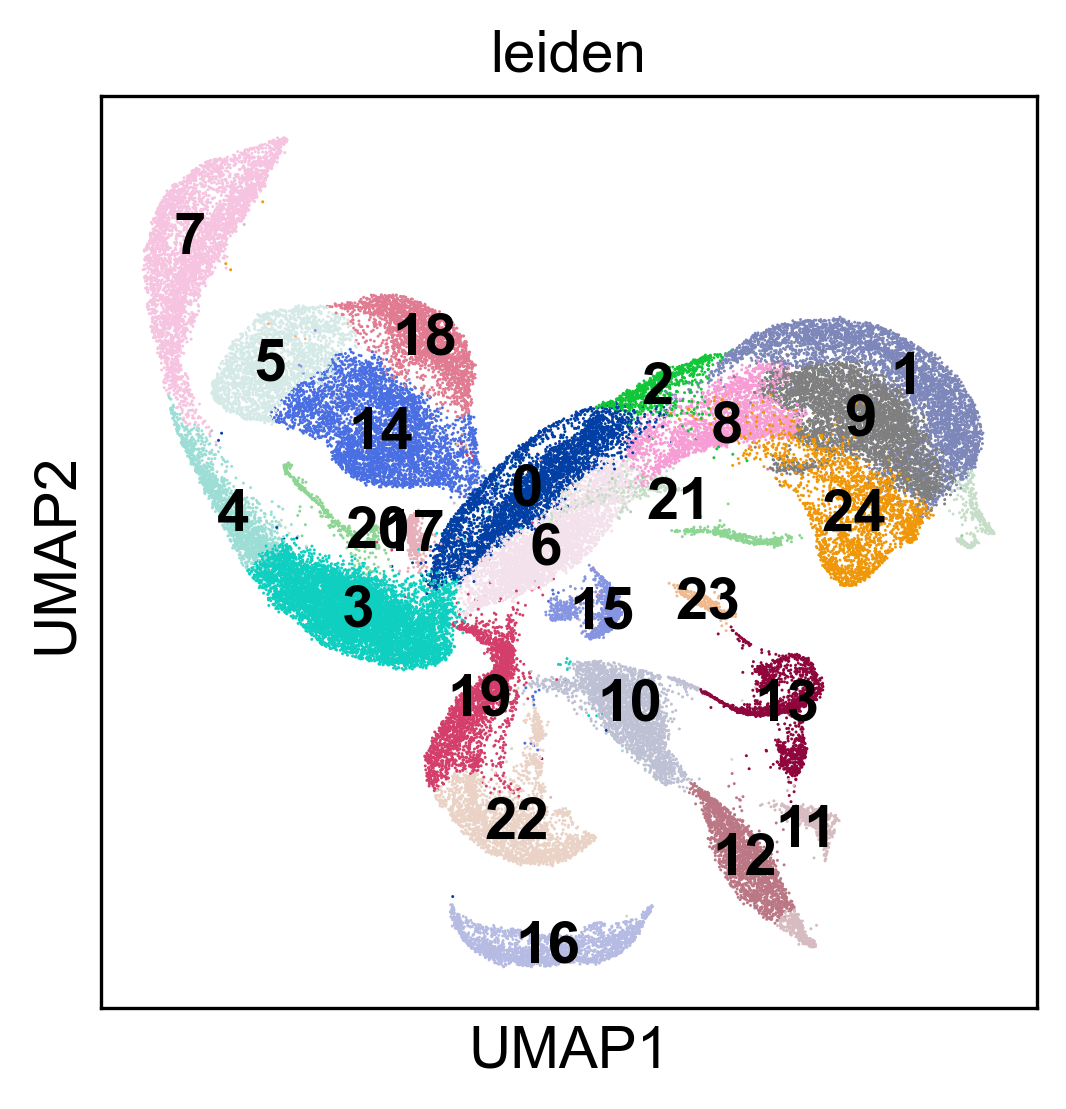

In [3]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata,color="leiden",legend_loc="on data")

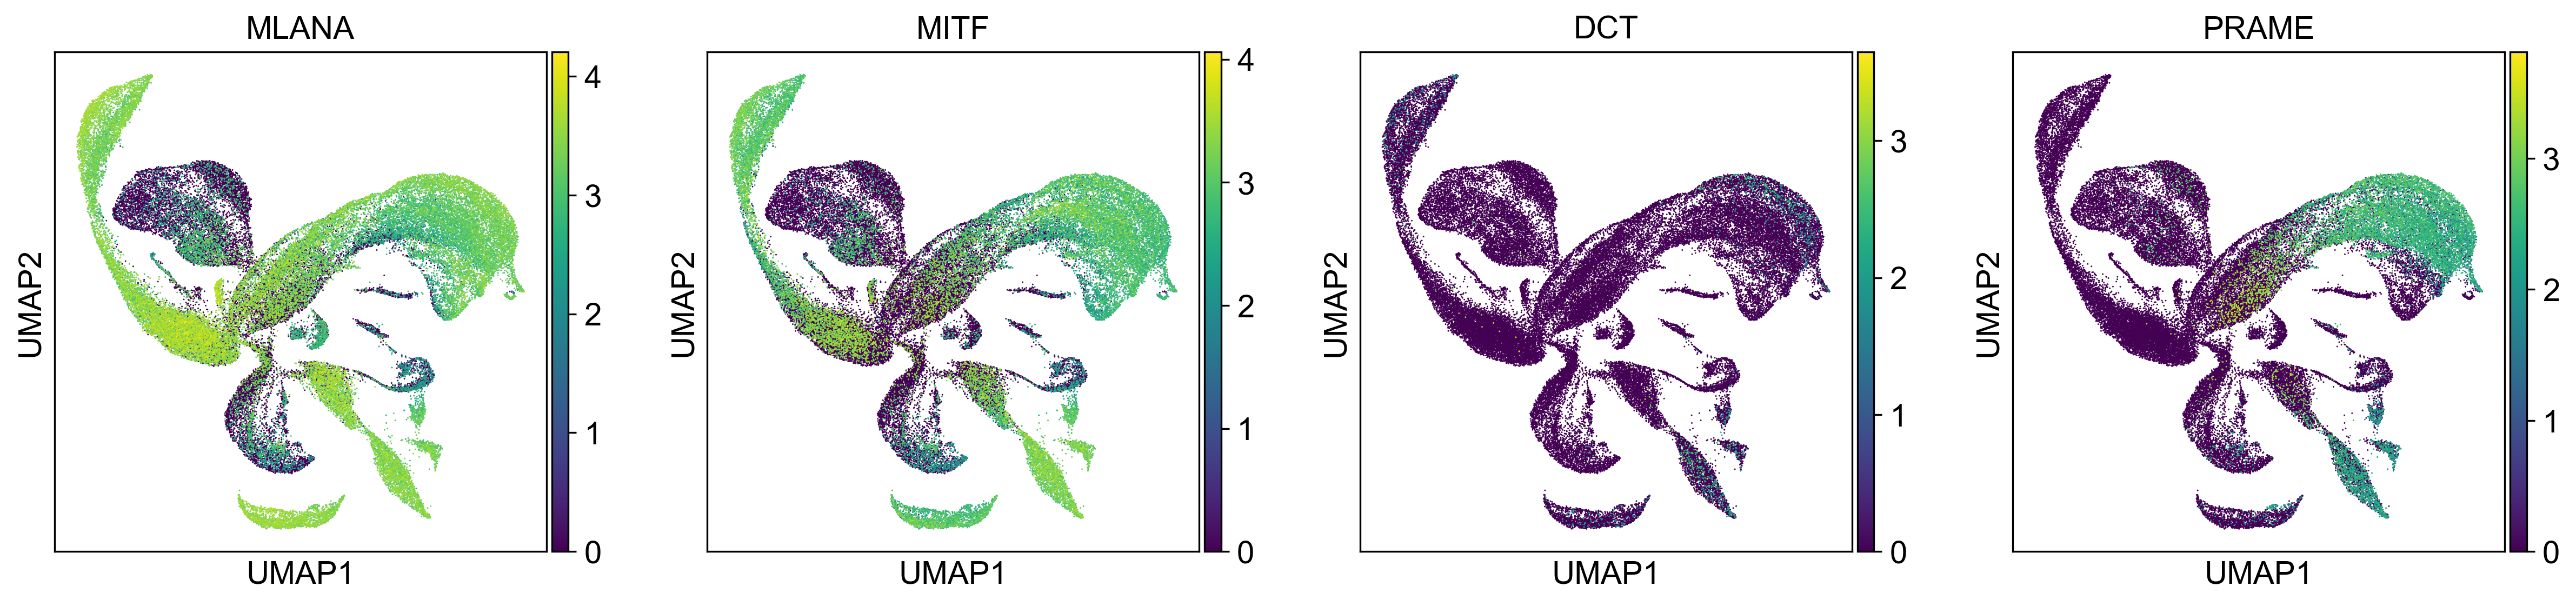

In [5]:
sc.pl.umap(adata,color=["MLANA", "MITF", "DCT","PRAME"])

In [4]:
adata=adata[adata.obs.leiden.isin(["0","6","2","8","9","1","24"]),]

In [5]:
adata.obs["sample"].value_counts()

UMM064      7097
UMM059      5096
UMM061      4454
UMM065      2098
UMM067L      910
UMM069       562
UMM062       320
UMM063        10
BSSR0022       9
UMM066         9
UMM041L        2
Name: sample, dtype: int64

In [6]:
adata=adata[adata.obs["sample"].isin(["UMM059"])]

In [7]:
sc.pp.filter_genes(adata,min_cells=3)

filtered out 6685 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


In [8]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger")

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
import cupy as cp
import rapids_scanpy_funcs as rap
scaled = cp.array(adata[:,adata.var["highly_variable"]].X.todense(), order="F")
scaled = rap.scale(scaled, max_value=10)

In [10]:
from cuml import PCA
adata.obsm["X_pca"] = (PCA(n_components=50).fit_transform(scaled)).get()

In [150]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=5,method="rapids")
sc.tl.umap(adata,method="rapids")

from scanpy._utils import _choose_graph
adjacency = _choose_graph(adata,None,None)
import cudf
import cugraph
import pandas as pd
offsets = cudf.Series(adjacency.indptr)
indices = cudf.Series(adjacency.indices)
weights = None
g = cugraph.Graph()
g.add_adj_list(offsets, indices, weights)
leiden_parts, _ = cugraph.leiden(g,resolution=0.4)
groups = leiden_parts.to_pandas().sort_values('vertex')[['partition']].to_numpy().ravel()
adata.obs["leiden"]=groups.astype(str)

/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/cugraph/structure/graph.py:623: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  warnings.warn(


/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden' as categorical


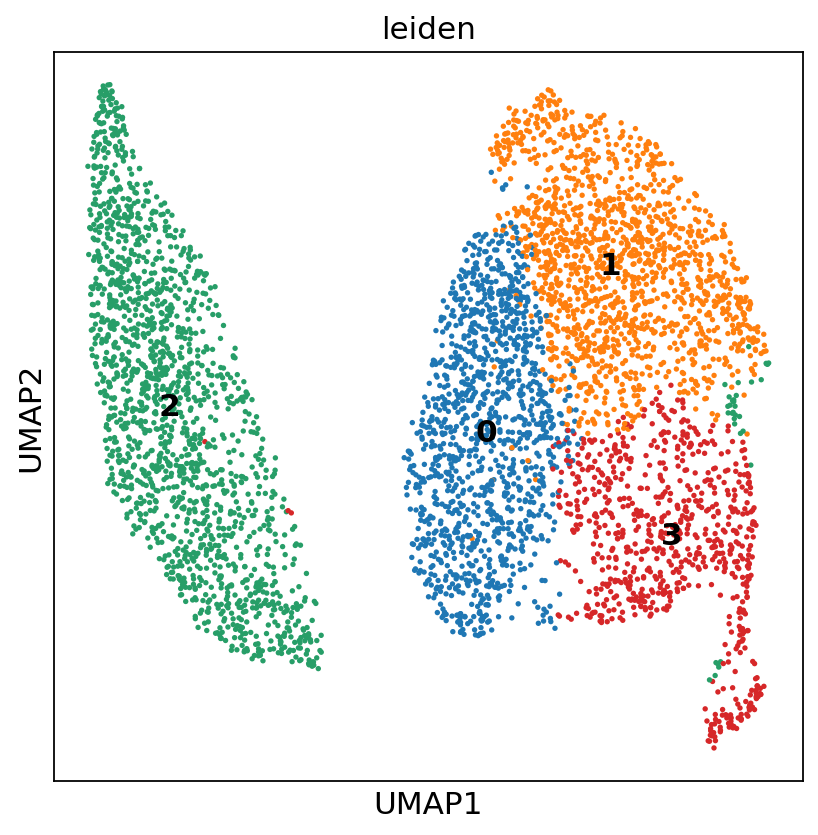

In [151]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

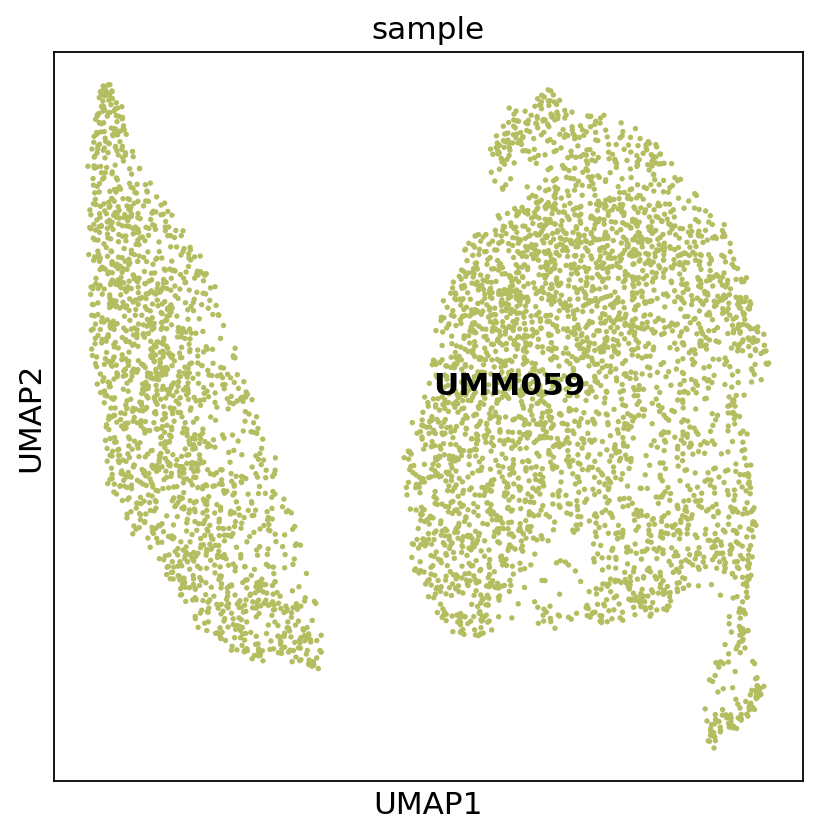

In [152]:
sc.pl.umap(adata,color="sample",legend_loc="on data")

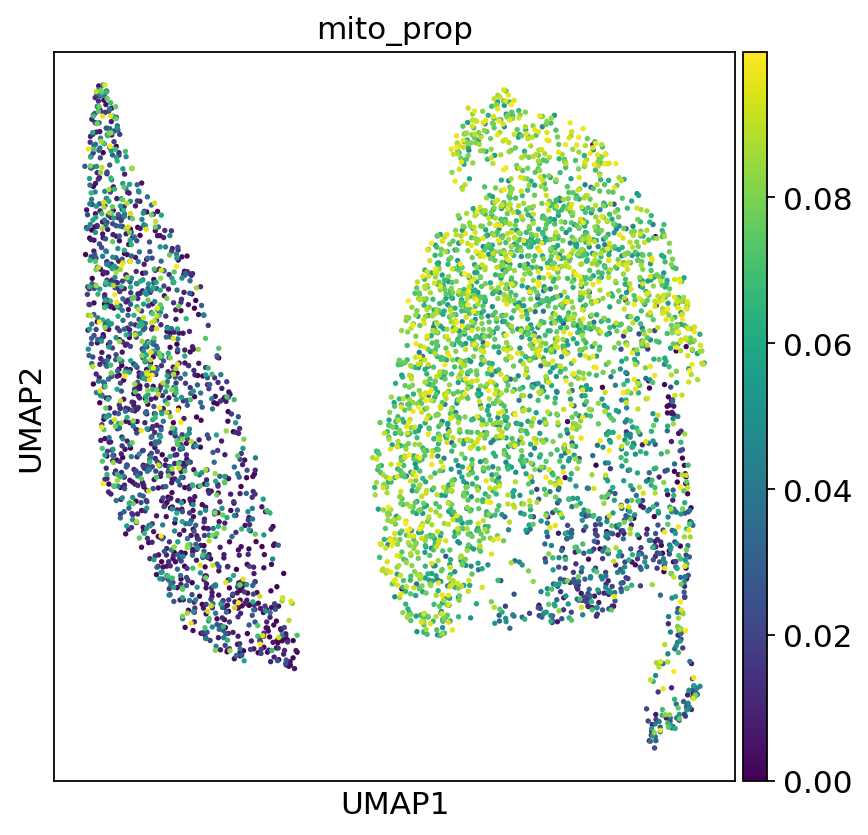

In [153]:
sc.pl.umap(adata,color="mito_prop",legend_loc="on data")

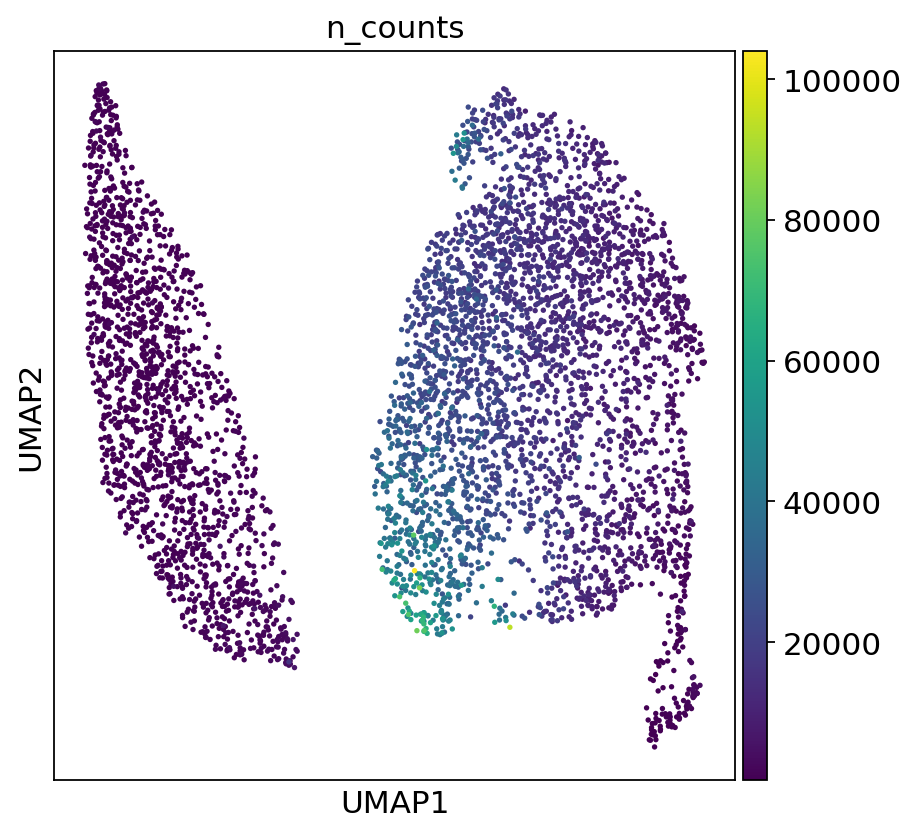

In [154]:
sc.pl.umap(adata,color="n_counts",legend_loc="on data")

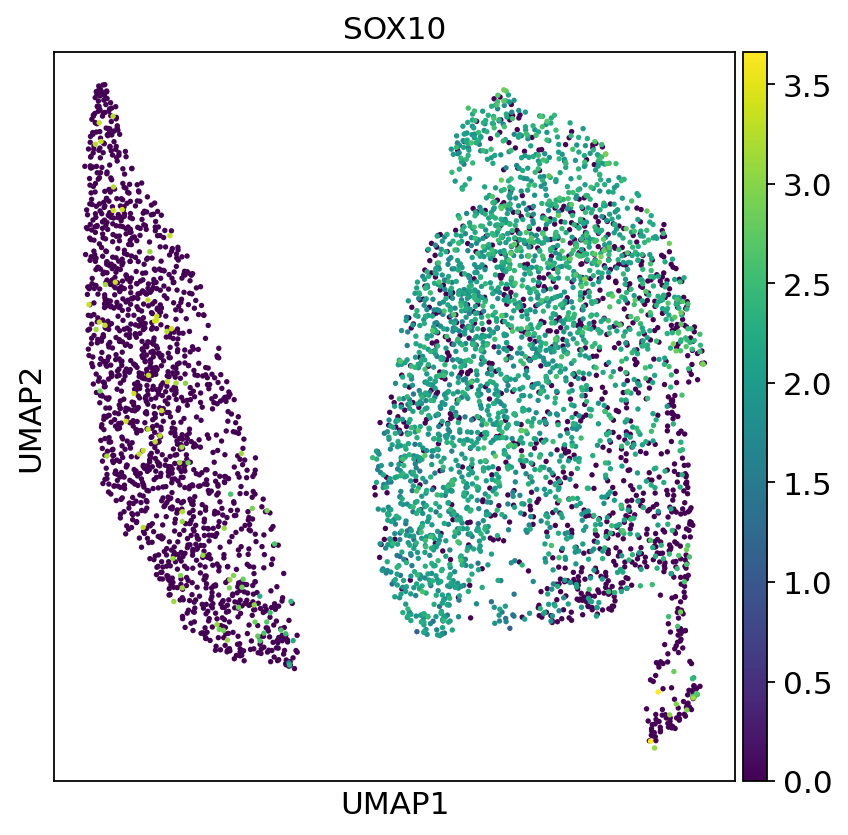

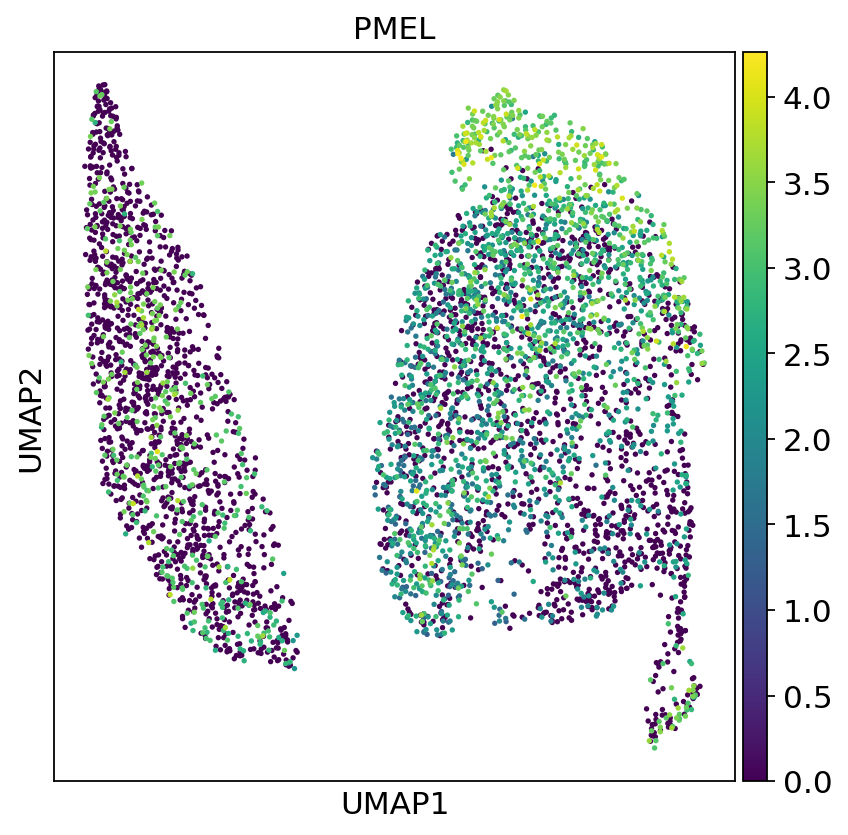

In [155]:
sc.pl.umap(adata,color="SOX10",legend_loc="on data")
sc.pl.umap(adata,color="PMEL",legend_loc="on data")

In [131]:
adata.layers["scaled"]=sc.pp.scale(adata.X,copy=True)

In [160]:
sc.tl.rank_genes_groups(adata,groupby="leiden",method="wilcoxon")

In [157]:
sc.tl.dendrogram(adata,"leiden")

/home/lfaure/miniconda3/envs/gpu/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


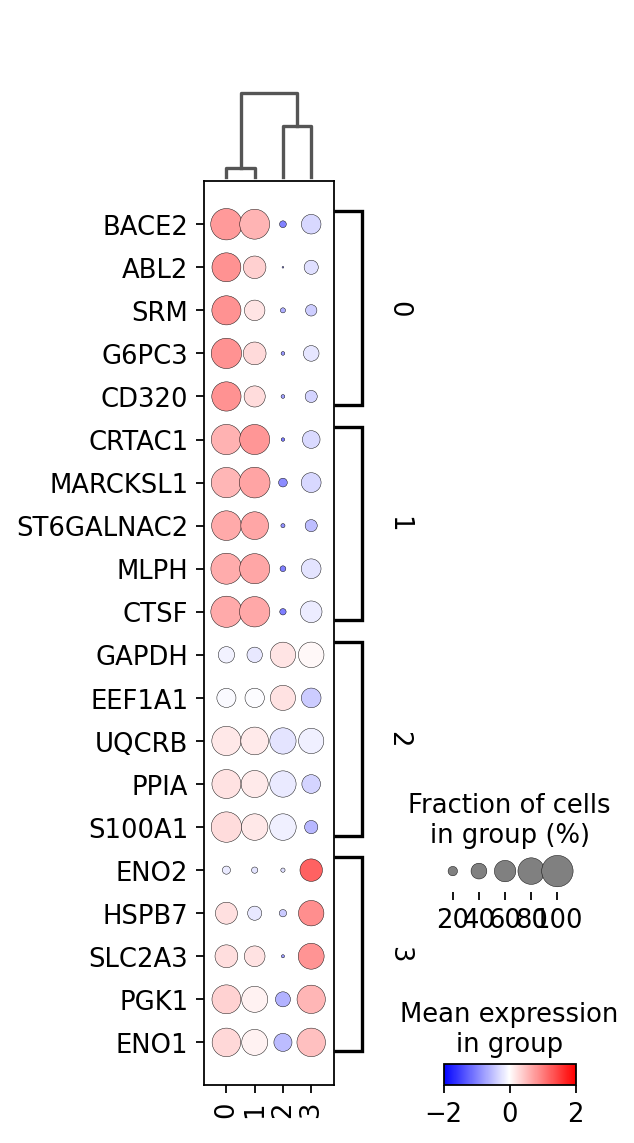

In [162]:
sc.pl.rank_genes_groups_dotplot(adata,cmap="bwr",layer="scaled",n_genes=5,vmin=-2,vmax=2,swap_axes=True)

In [17]:
import palantir

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [18]:
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names),knn=100)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [19]:
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

In [20]:
tsne = palantir.utils.run_tsne(ms_data,n_jobs=-1,perplexity=200)

In [21]:
adata.obsm["X_palantir"]=ms_data.values

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


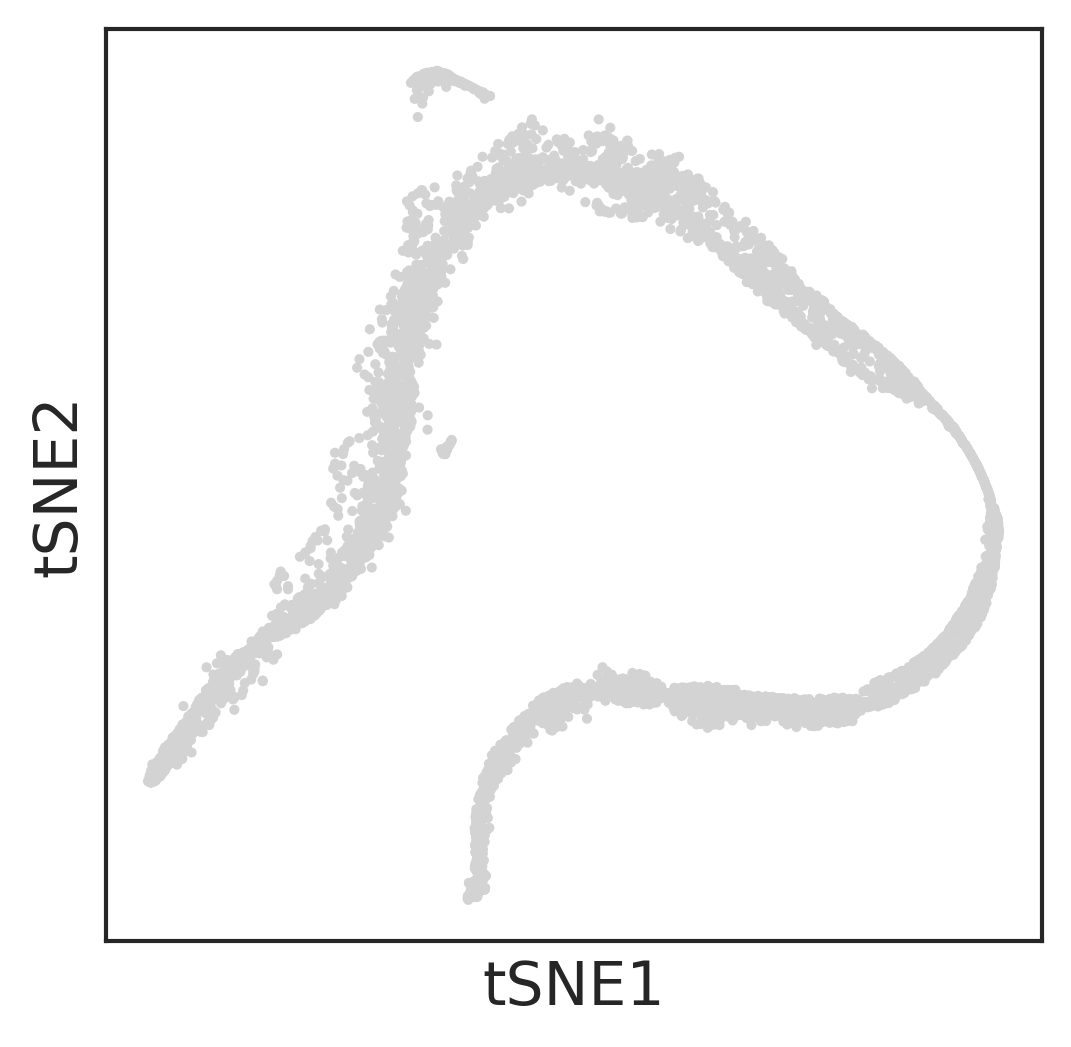

In [22]:
adata.obsm["X_tsne"]=tsne.values
sc.pl.tsne(adata)

In [23]:
adata_raw=sc.read("adata_raw.h5ad")

In [24]:
adata_raw=adata_raw[adata.obs_names]

In [25]:
sc.pp.filter_genes(adata_raw,min_cells=1)

filtered out 6270 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


In [7]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [27]:
%%R -i adata_raw -o ct
source("CytoTRACE.R")
rownames(adata_raw@assays@data$X)=rownames(adata_raw)
colnames(adata_raw@assays@data$X)=colnames(adata_raw)
results=CytoTRACE(adata_raw@assays@data$X,ncores=1)
ct=results$CytoTRACE

R[write to console]: The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

R[write to console]: CytoTRACE will be run on 5 sub-sample(s) of approximately 1019 cells each using 1 / 1 core(s)

R[write to console]: Pre-processing data and generating similarity matrix...

R[write to console]: Calculating gene counts signature...

R[write to console]: Smoothing values with NNLS regression and diffusion...

R[write to console]: Calculating genes associated with CytoTRACE...

R[write to console]: Done



In [28]:
adata.obs["CytoTRACE"]=ct

In [227]:
sc.set_figure_params(dpi_save=600)

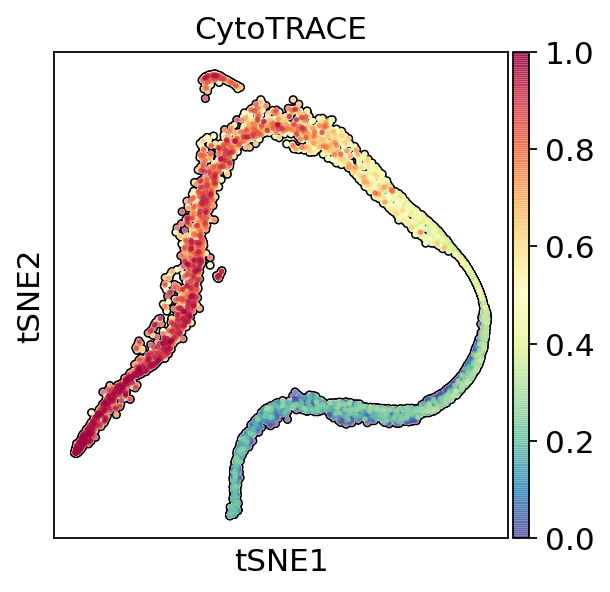

In [229]:
sc.pl.tsne(adata,color="CytoTRACE",color_map="Spectral_r",add_outline=True,
          save="Melanoma_CytoTRACE.png")

In [30]:
adata.write_h5ad("adata_2_pal.h5ad")